In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 32.6 MB/s eta 0:00:00


In [ ]:
# Import Libs
import geopandas as gpd
import rasterio
import rasterio.mask
import numpy as np
import pandas as pd

# Func
def calculate_zonal_statistics(raster_path, vector_path, id_column='id'):

    # Load GeoJSON
    polygons = gpd.read_file(vector_path)

    # Open Raster and CRS check
    with rasterio.open(raster_path) as src:
        raster_crs = src.crs
        if polygons.crs != raster_crs:
            polygons = polygons.to_crs(raster_crs)

        # Intl. blank sets
        stats = {id_column: [], 'Mean_Value': [], 'StdDev_Value': []}

        # Calculate stats
        for idx, row in polygons.iterrows():
            out_image, _ = rasterio.mask.mask(src, [row['geometry']], crop=True)
            valid_data = out_image[0][out_image[0] != src.nodata]  # Filter NoData

            # Calculate mean & std dev
            stats[id_column].append(row[id_column])
            stats['Mean_Value'].append(valid_data.mean() if valid_data.size > 0 else np.nan)
            stats['StdDev_Value'].append(valid_data.std() if valid_data.size > 0 else np.nan)

    # Retrun DF
    return pd.DataFrame(stats)

# Func Input
ndvi_raster_path = '/content/drive/MyDrive/GSA_Data/lab-6-task-data/illinois_cdl.tif'
geojson_path = '/content/drive/MyDrive/GSA_Data/lab-6-task-data/grid.geojson'

# Call Func
zonal_stats_df = calculate_zonal_statistics(ndvi_raster_path, geojson_path, id_column='id')
print(zonal_stats_df)


      id  Mean_Value  StdDev_Value
0     41   42.567612     69.122660
1     42   52.106858     74.766739
2     61  114.944679     62.926287
3     62  111.334992     64.471236
4     63   91.909079     73.092487
..   ...         ...           ...
367  560   25.944942     53.334536
368  561   62.805456     69.158750
369  562   58.369444     69.111405
370  581   10.186583     32.874475
371  582   20.441531     47.781531

[372 rows x 3 columns]


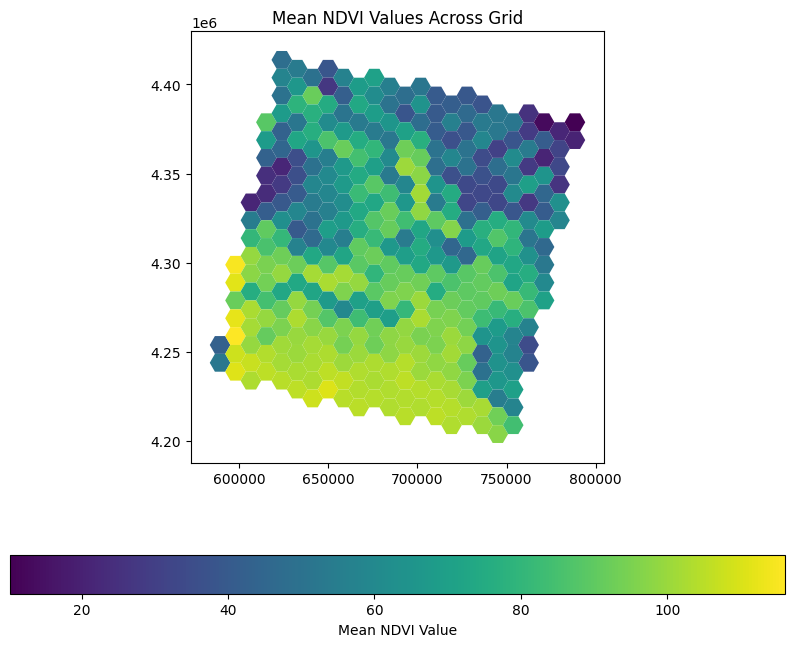

In [ ]:
import matplotlib.pyplot as plt

# Load
grids_gdf = gpd.read_file(geojson_path)

# Merge
merged_gdf = grids_gdf.merge(zonal_stats_df, on='id')

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
merged_gdf.plot(column='Mean_Value', cmap='viridis', legend=True,
                legend_kwds={'label': "Mean NDVI Value", 'orientation': "horizontal"},
                ax=ax)
ax.set_title("Mean NDVI Values Across Grid")
plt.show()
